# Lab 2: Quantization and entropy coding

This lab aims to help understand the quantization of a sound signal using with entropy coding, in particular Huffman coding.

## Relevant concepts:

### Quantization noise
Noise resulting from quantizing a signal. The difference between the original signal and the signal obtained after quantization.

### Signal to Noise Ratio (SNR)
A measure that compares the level of a desired signal to the level of background noise. SNR is defined as the ratio of signal power to noise power, often expressed in decibels. A ratio higher than 1:1 (greater than 0 dB) indicates more signal than noise.

### Entropy
Signal entropy is the minimum number of bits required to describe a encode a signal. It has its maximum value when all probabilities are equal (we assume the number of possible states. is finite), and the resulting value for entropy is the logarithm of the number of states. In audio a high entropy signal could be noise or a complex musical piece with many different levels of loudness and frequency changes.

### Huffman coding
A data compression method, independent of data type, that is commonly used for lossless data compression. It works by assigning shorter codes to more frequent symbols and longer codes to less frequent symbols, thus reducing the overall data size when encoded.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import get_window
from scipy.fft import fft
import IPython.display as ipd
from scipy.io.wavfile import read
import heapq
from collections import Counter

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# functions used in the whole lab
def read_sound(file):
  """ read a mono wav sound file, assuming is mono, and convert it to a floating point array
    Args:
      file (str): File name
    Returns:
      sound_array (numpy.array): Array of samples as floating point values between -1 and 1
      sampling_rate (int): Sampling rate
  """
  sampling_rate, x = read(file)
  # convert to floating point values between -1 and 1, assuming x are 16 bit integers
  sound_array = np.float32(x) / 2**15
  return sound_array, sampling_rate

def display_sound(sound_array, sampling_rate=44100):
  """ Display signal sound_array
    Args:
      sound_array (numpy.array): Array of samples
      sampling_rate (int): Sampling rate
  """
  plt.figure(0, figsize=(10, 4))
  time_indexes = np.arange(0, sound_array.size/sampling_rate, 1.0/sampling_rate)
  plt.plot(time_indexes, sound_array)
  plt.xlabel('time (seconds)')
  plt.ylabel('amplitude')
  ipd.display(ipd.Audio(data=sound_array, rate=sampling_rate))
  plt.show()

def display_spectrum(sound_array, sampling_rate=44100):
  """ Display magnitude spectrum of signal sound_array
    Args:
      sound_array (numpy.array): Array of samples
      sampling_rate (int): Sampling rate
  """
  window = get_window('hann', sound_array.size)
  spectrum = fft(window*sound_array)
  magnitude_spectrum= 20*np.log10(abs(spectrum[:spectrum.size//2]))

  plt.figure(0, figsize=(10, 5))
  frequency_indexes = np.arange(0, sampling_rate/2, sampling_rate/spectrum.size)
  plt.plot(frequency_indexes, magnitude_spectrum)
  plt.xlabel('frequency (Hz)')
  plt.ylabel('amplitude (dB)')
  plt.show()

def display_spectrogram(sound_array, hop_size=256, fft_size=512, sampling_rate=44100):
  """ Display magnitude spectrogram of signal sound_array
    Args:
      sound_array (numpy.array): Array of samples
      hop_size (int): window hop size
      fft_size (int): Spectrogram fft size
      sampling_rate (int): Sampling rate of sound
  """
  sample_index = 0
  window = get_window('hann', fft_size)
  magnitude_spectrogram = []
  while sample_index < sound_array.size-fft_size:
    spectrum = fft(window*sound_array[sample_index:sample_index+fft_size])
    magnitude_spectrum= 20*np.log10(abs(spectrum[:spectrum.size//2]))
    magnitude_spectrogram.append(magnitude_spectrum)
    sample_index += hop_size

  plt.figure(figsize=(10, 5))
  time_indexes = np.arange(0, sample_index/sampling_rate, hop_size/sampling_rate)
  frequency_indexes = np.arange(0, sampling_rate/2, sampling_rate/fft_size)
  plt.pcolormesh(time_indexes, frequency_indexes, np.transpose(magnitude_spectrogram), shading='nearest', cmap='inferno')
  plt.colorbar(format='%+2.0f dB')
  plt.xlabel('time (seconds)')
  plt.ylabel('frequency (Hz)')
  plt.show()

# Part 1 Scalar quantization
Explore the impact of quantization in a sound file by measuring its SNR. Modify the code given as needed and answer the questions given.

In [ ]:
def quantize_signal(x, original_bits, target_bits):
  """Quantizes a signal x, assuming it originally had original_bits bits per sample, to target_bits per sample.
  Args:
    x (numpy.array): Array of samples as floating point values between -1 and 1
    original_bits (int): Number of bits of the signal that x represents
    target_bits (int): Number of bits per sample of the output signal
  """
  # Scaling the signal to the range of [0, 2^target_bits - 1]
  x_scaled = (x - np.min(x)) / (np.max(x) - np.min(x)) * (2**target_bits - 1)
  # Quantize by rounding
  x_quantized = np.round(x_scaled)
  # Re-scaling back to the original amplitude range
  x_output = (x_quantized / (2**target_bits - 1)) * (np.max(x) - np.min(x)) + np.min(x)
  return x_output

def calculate_snr(x, y):
    """Calculate the Signal-to-Noise Ratio (SNR) of a quantized signal.
    Args:
    x (numpy.array): The original signal
    y (numpy.array): The quantized signal
    Returns:
    snr_db (float): The SNR in decibels (dB)
    """
    # Ensure that x and y are numpy arrays
    x = np.asarray(x)
    y = np.asarray(y)
    # Calculate the signal power (mean squared value of the original signal)
    signal_power = np.mean(x ** 2)
    # Calculate the noise power (mean squared difference between original and quantized signal)
    noise_power = np.mean((x - y) ** 2)
    # Compute the SNR
    snr = signal_power / noise_power
    # Convert SNR to decibels (dB)
    snr_db = 10 * np.log10(snr)
    return snr_db

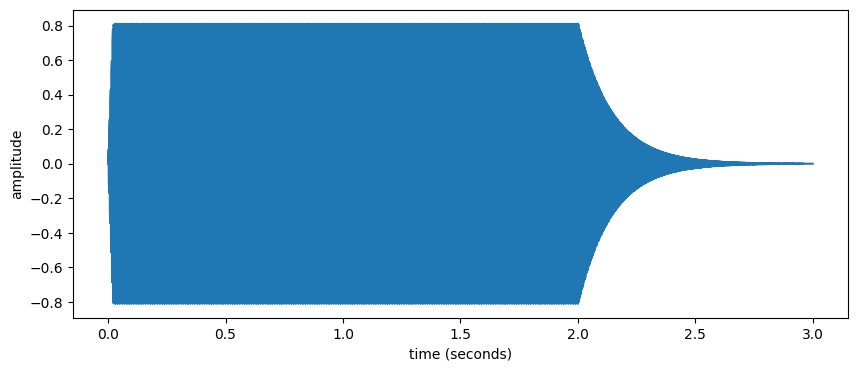

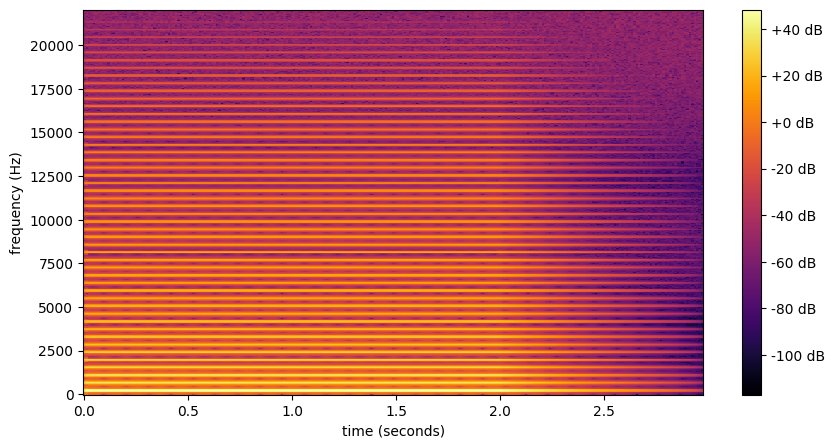

In [ ]:
# read and display a sound
# sound_array, sampling_rate = read_sound('/content/drive/MyDrive/UNI/UPF/5è CURS/1r TRIM/SISTEMES DE CODIFICACIÓ ÀUDIO I VÍDEO/audio-coding-materials-main/sounds/721313-hangpan.wav')
sound_array, sampling_rate = read_sound('/content/drive/MyDrive/UNI/UPF/5è CURS/1r TRIM/SISTEMES DE CODIFICACIÓ ÀUDIO I VÍDEO/audio-coding-materials-main/sounds/synthetic.wav')
display_sound(sound_array,sampling_rate)
display_spectrogram(sound_array, 512, 1024, sampling_rate)

SNR: 81.44001007080078 dB


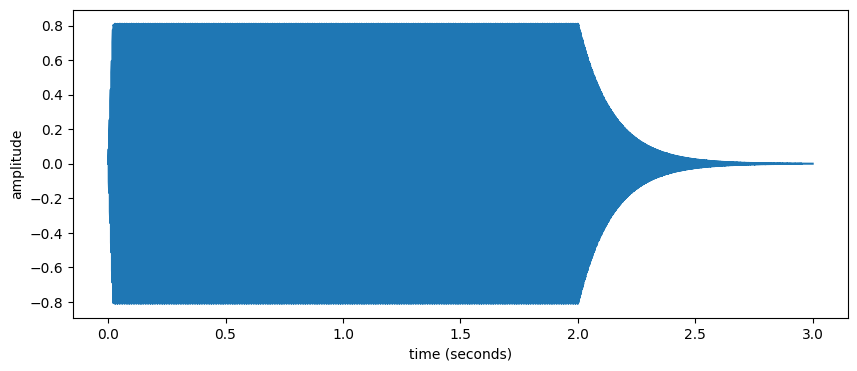

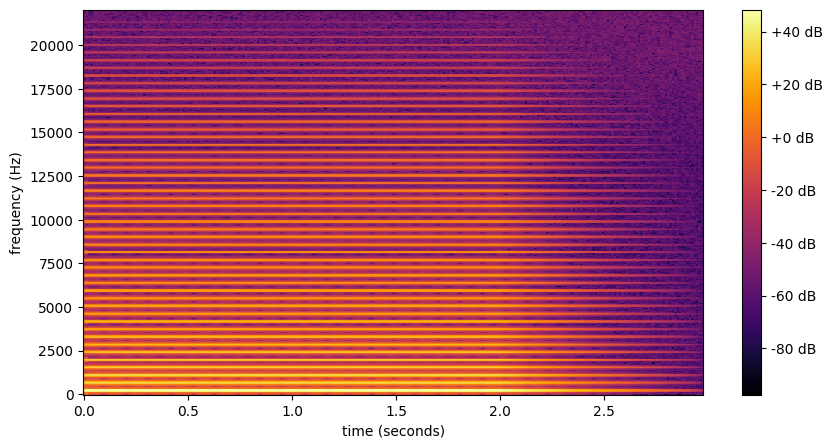

In [ ]:
# quantize the sound (originally at 16 bits) to progressively fewer number of bits
# until you star hearing the quantization noise and compute its SNR
number_of_bits = 13
quantized_sound_array = quantize_signal(sound_array, 16, number_of_bits)

# compute SNR
snr = calculate_snr(sound_array, quantized_sound_array)
print("SNR: %r dB" %snr)

# display quantized sound
display_sound(quantized_sound_array,sampling_rate)
display_spectrogram(quantized_sound_array, 512, 1024, sampling_rate)

**Questions: (answer in this text cell)**

1. **Choose a sound, not `synthetic.wav`, from the sound directory and change the original bit rate (they all have a bit rate of 16bits). What is the lowest bit rate at which you start hearing the quantization noise? Explain the result using the SNR value and the spectrogram.**

  El  bit rate més baix per al qual no he sentit el soroll de la quantització ha sigut 13 bits. El valor de Signal to Nose Ratio m'ha donat 67.11 dB, que indica que el senyal és 67,11 vegades més fort que el soroll de fons. Això es deu a la menor resolució en la quantització, que impedeix representar amb precisió els detalls del senyal. Si comparem els espectogrames, veiem que a 13 bits són pràcticament iguals, tot i que al segon veiem com les freqüències més altes comencen a perdre definició o ja no són visibles, ja que els detalls més petits s'han perdut a causa de la quantització.

2. **Now compare the results with doing the same in `synthetic.wav`. Try the same bit rate change for `synthetic.wav`? Does it result into the same SNR? Do you hear the quantization noise equally? If not, explain why not?**

  Si provem amb el mateix bit rate per al so sintètic, veiem que el valor del SNR puja a 81.44 dB i que el soroll de la quantització es imperceptible. Si comparem els espectogrames veiem que amb la quantització es perden detalls i les frequències altes no són tan visibles. Per al so sintètic, podriem utilitzar un bit rate més baix que 13 bits sense sentir el soroll de la quantització. Tot això és degut a que el so sintètic té un espectre de freqüències més uniforme i controlat, el que el fa més tolerant a la quantització. A més, el seu waveform constant redueix la percepció del soroll de quantització.



# Part 2 - Entropy calculation

Compute the probability distributions and the entropy of different signals. Correlate these measurements with the characteristics of the sounds. Answer the questions given and modify the code to support your answers.

In [ ]:
def calculate_entropy(probs):
    """
    Args:
        probs (np.array): Array of probs. for each symbol in the source
    Returns:
        H (float): entropy value
    """
    H = 0
    for p in probs:
      if(p > 0):
        H -= p * np.log2(p)
      elif(p < 0):
        return np.nan
    return H

def get_prob_per_symbol(y):
    """ Get symbol occurrence probability
    Args:
        x (np.array): Input signal
    Returns:
        (np.array, np.array): (sorted symbols, corresponding probabilities)
    """
    symbols, count = np.unique(y, return_counts=True)
    probs = count / sum(count)
    return symbols, probs

In [ ]:
# read a sound

sound_array1, sampling_rate1 = read_sound('/content/drive/MyDrive/UNI/UPF/5è CURS/1r TRIM/SISTEMES DE CODIFICACIÓ ÀUDIO I VÍDEO/audio-coding-materials-main/sounds/721313-hangpan.wav')
sound_array2, sampling_rate2 = read_sound('/content/drive/MyDrive/UNI/UPF/5è CURS/1r TRIM/SISTEMES DE CODIFICACIÓ ÀUDIO I VÍDEO/audio-coding-materials-main/sounds/406609-tuba.wav')
sound_array3, sampling_rate3 = read_sound('/content/drive/MyDrive/UNI/UPF/5è CURS/1r TRIM/SISTEMES DE CODIFICACIÓ ÀUDIO I VÍDEO/audio-coding-materials-main/sounds/750340-background-music.wav')

display_spectrogram(sound_array1, 512, 1024, sampling_rate1)

# Quantize the sound_array by giving the number of bits to use
nbits = 8
x_scaled = sound_array1 * 2**nbits
x_quantized = np.int16(np.round(x_scaled))

# compute the probabilities of all the signal values
symbols, probs = get_prob_per_symbol(x_quantized)

plt.figure(0, figsize=(10, 4))
plt.plot(symbols, probs, 'x')
plt.xlabel("sound_array1"), plt.ylabel("Probability")
plt.show()

# Quantize the sound_array by giving the number of bits to use
nbits = 4
x_scaled = sound_array1 * 2**nbits
x_quantized = np.int16(np.round(x_scaled))

# compute the probabilities of all the signal values
symbols, probs = get_prob_per_symbol(x_quantized)

plt.figure(0, figsize=(10, 4))
plt.plot(symbols, probs, 'x')
plt.xlabel("sound_array1"), plt.ylabel("Probability")
plt.show()

# compute the entropy value
h = calculate_entropy(probs)
print("Entropy Sound 1:", h)

display_spectrogram(sound_array2, 512, 1024, sampling_rate2)

# Quantize the sound_array by giving the number of bits to use
nbits = 8
x_scaled = sound_array2 * 2**nbits
x_quantized = np.int16(np.round(x_scaled))

# compute the probabilities of all the signal values
symbols, probs = get_prob_per_symbol(x_quantized)

plt.figure(0, figsize=(10, 4))
plt.plot(symbols, probs, 'x')
plt.xlabel("sound_array2"), plt.ylabel("Probability")
plt.show()

# compute the entropy value
h = calculate_entropy(probs)
print("Entropy Sound 2:", h)

display_spectrogram(sound_array3, 512, 1024, sampling_rate3)

# Quantize the sound_array by giving the number of bits to use
nbits = 8
x_scaled = sound_array3 * 2**nbits
x_quantized = np.int16(np.round(x_scaled))

# compute the probabilities of all the signal values
symbols, probs = get_prob_per_symbol(x_quantized)

plt.figure(0, figsize=(10, 4))
plt.plot(symbols, probs, 'x')
plt.xlabel("sound_array3"), plt.ylabel("Probability")
plt.show()

# compute the entropy value
h = calculate_entropy(probs)
print("Entropy Sound 3:", h)

Output hidden; open in https://colab.research.google.com to view.

**Questions:**

1. **Compare the probability distributions of different sounds. Choose 3 sounds from the sound directory that would result in distinct probabilty distributions. Compute their probability distributions and describe them, their similarities and differences. Show the plots in the cell above of all the results and explain them here.**

- La distribució de probabilitat del hangpan té una forma normal centrada en 0, cosa que vol dir que les amplituds es concentren al voltant del valor mitjà, mostrant un so consistent i melòdic.

- La distribució del so de la tuba té una forma en M amb tres pics a -150, 0 i 150, indicant que hi ha una varietat de freqüències i un so ric, típic dels instruments de metall.

- La distribució de la música de fons també és normal i centrada en 0, però amb probabilitats molt altes al voltant d’aquest valor. Això reflecteix un so uniforme i coherent, caracteritzant la música ambiental.

2. **For one of the sounds, change the number of "symbols" used by changing the quantization value. Give the resulting number of symbols. Compare the resulting probability distributions for the different quantizations. Explain the result.**

  He canviat el nombre de bits del primer so de 8 (2^8 = 256 símbols) a 4, el que ens dona un total de 2^4 = 16 símbols. Això significa que la representació del senyal s'ha simplificat considerablement, perdent detalls i matisos importants.
  Si mirem la distribució de probabilitat, veiem que té molts menys punts i més separats. Això es deu a que, augmentant la quantització (reduint el nombre de símbols), els valors originals del senyal s'han agrupat en menys nivells, la qual cosa provoca una pèrdua de variabilitat i un augment del soroll de quantització.


3. **Compute the entropy values of the distributions obtained in question 1 and explain the relation between the entropy values obtained and the shape of the probability distributions.**

  Al so del hangpan hem obtingut una entropia de 3.24 , al so de la tuba de 8.65, i al so de música de fons de 6.58. L'entropia baixa del hangpan mostra que la seva distribució és més concentrada i homogènia, cosa que indica un so consistent. En canvi, la tuba, amb l'entropia més alta, té una distribució més dispersa, reflectint la seva diversitat tonal. La música de fons es troba en un punt intermèdia, amb més variabilitat que el hangpan però menys que la tuba. Així, l'entropia ens ajuda a entendre com de variats són els sons: una entropia baixa indica menys diversitat, mentre que una alta indica més variabilitat, cosa que sabíem gràcies a la definició de la entropia.
---

# Part 3 Huffman encoding
Encode and decode a signal using Huffman coding and understand its effectiveness in different types of sounds. Answer the questions given and modify the code to support your answers.

In [ ]:
# functions used to implement huffman coding with the heap queue algorithm
# (priority queue algorithm)

# Define a tree node
class Node:
    def __init__(self, char=None, freq=0, left=None, right=None):
        self.char = char
        self.freq = freq
        self.left = left  # left child
        self.right = right  # right child

    # Override the less-than operator for the priority queue to work
    def __lt__(self, other):
        return self.freq < other.freq

def build_huffman_tree(frequencies):
    heap = [Node(char, freq) for char, freq in frequencies.items()]
    heapq.heapify(heap)

    while len(heap) > 1:
        left = heapq.heappop(heap)
        right = heapq.heappop(heap)
        merged = Node(None, left.freq + right.freq, left, right)
        heapq.heappush(heap, merged)

    return heap[0]

def generate_huffman_codes(node, prefix="", code_map={}):
    if node is None:
        return

    if node.char is not None:
        code_map[node.char] = prefix
    else:
        generate_huffman_codes(node.left, prefix + "0", code_map)
        generate_huffman_codes(node.right, prefix + "1", code_map)

    return code_map

def encode(array, code_map):
    return ''.join(code_map[char] for char in array)

def decode(encoded_string, root):
    decoded_array = []
    node = root
    for bit in encoded_string:
        if bit == '0':
            node = node.left
        else:
            node = node.right

        if node.char is not None:
            decoded_array.append(node.char)
            node = root

    return decoded_array

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import IPython.display as ipd

# Load sounds
sound_arrays = [
    read_sound('/content/drive/MyDrive/UNI/UPF/5è CURS/1r TRIM/SISTEMES DE CODIFICACIÓ ÀUDIO I VÍDEO/audio-coding-materials-main/sounds/721313-hangpan.wav'),
    read_sound('/content/drive/MyDrive/UNI/UPF/5è CURS/1r TRIM/SISTEMES DE CODIFICACIÓ ÀUDIO I VÍDEO/audio-coding-materials-main/sounds/406609-tuba.wav'),
    read_sound('/content/drive/MyDrive/UNI/UPF/5è CURS/1r TRIM/SISTEMES DE CODIFICACIÓ ÀUDIO I VÍDEO/audio-coding-materials-main/sounds/750340-background-music.wav')
]

# Results storage
results = []

for sound_array, sampling_rate in sound_arrays:
    # Step 1: Calculate frequencies of each signal value
    frequencies = Counter(sound_array)
    total_samples = len(sound_array)
    probabilities = {key: freq / total_samples for key, freq in frequencies.items()}

    # Plot the probability distribution
    plt.figure(figsize=(10, 6))
    plt.plot(probabilities.keys(), probabilities.values(), 'x')
    plt.title("Probability Distribution of Signal")
    plt.xlabel("Value")
    plt.ylabel("Probability")
    plt.grid(True)
    plt.show()

    # Step 2: Build the Huffman tree
    root = build_huffman_tree(frequencies)

    # Step 3: Generate Huffman codes
    huffman_codes = generate_huffman_codes(root)

    # Step 4: Encode the input array
    encoded_x = encode(sound_array, huffman_codes)

    # Step 5: Decode the encoded string
    decoded_x = np.array(decode(encoded_x, root))

    # Calculate the sizes and compression ratios
    original_size_bits = len(sound_array) * 16  # Assuming 16-bit audio
    encoded_size_bits = len(encoded_x)
    compression_ratio = original_size_bits / encoded_size_bits
    compression_percentage = (1 - (encoded_size_bits / original_size_bits)) * 100

    # Store the results
    results.append({
        'original_size_bits': original_size_bits,
        'encoded_size_bits': encoded_size_bits,
        'compression_ratio': compression_ratio,
        'compression_percentage': compression_percentage,
        'num_codes': len(huffman_codes),
        'sampling_rate': sampling_rate
    })

    # Display sound
    ipd.display(ipd.Audio(data=decoded_x, rate=sampling_rate))

# Output results
for i, result in enumerate(results):
    print(f"Sound {i + 1}:")
    print(f"Original Size (bits): {result['original_size_bits']}")
    print(f"Encoded Size (bits): {result['encoded_size_bits']}")
    print(f"Compression Ratio: {result['compression_ratio']:.2f}")
    print(f"Compression Percentage: {result['compression_percentage']:.2f}%")
    print(f"Number of Huffman Codes: {result['num_codes']}\n")


Output hidden; open in https://colab.research.google.com to view.

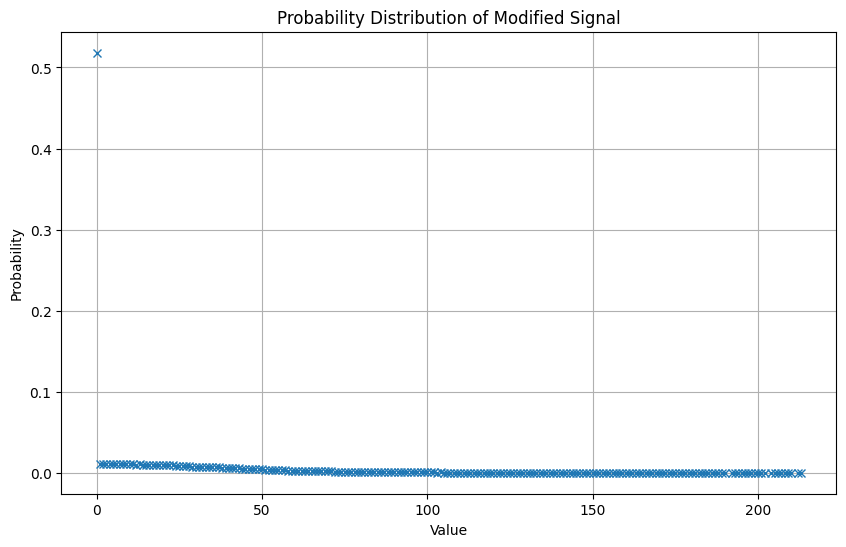

Original Size (bits): 4685216
Encoded Size (bits): 2365621
Compression Ratio: 1.98
Compression Percentage: 49.51%
Number of Huffman Codes: 53952


In [15]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import IPython.display as ipd
import soundfile as sf

# Load the first sound
sound_array, original_sampling_rate = read_sound('/content/drive/MyDrive/UNI/UPF/5è CURS/1r TRIM/SISTEMES DE CODIFICACIÓ ÀUDIO I VÍDEO/audio-coding-materials-main/sounds/721313-hangpan.wav')

# Step 1: Change the sampling rate to 22050 Hz
new_sampling_rate = 22050
duration = len(sound_array) / original_sampling_rate
new_length = int(new_sampling_rate * duration)
resampled_sound = np.interp(
    np.linspace(0, len(sound_array), new_length),
    np.arange(len(sound_array)),
    sound_array
)

# Step 2: Change the number of bits per sample to 8 bits
# Normalize and convert to int16 for saving, but treat as 8 bits for encoding
resampled_sound = np.clip((resampled_sound / np.max(np.abs(resampled_sound)) * 255), 0, 255).astype(np.uint8)

# Step 3: Calculate frequencies of each signal value
frequencies = Counter(resampled_sound)
total_samples = len(resampled_sound)
probabilities = {key: freq / total_samples for key, freq in frequencies.items()}

# Plot the probability distribution
plt.figure(figsize=(10, 6))
plt.plot(probabilities.keys(), probabilities.values(), 'x')
plt.title("Probability Distribution of Modified Signal")
plt.xlabel("Value")
plt.ylabel("Probability")
plt.grid(True)
plt.show()

# Step 4: Build the Huffman tree
root = build_huffman_tree(frequencies)

# Step 5: Generate Huffman codes
huffman_codes = generate_huffman_codes(root)

# Step 6: Encode the input array
encoded_x = encode(resampled_sound, huffman_codes)

# Step 7: Decode the encoded string
decoded_x = np.array(decode(encoded_x, root))

# Calculate the sizes and compression ratios
original_size_bits = len(resampled_sound) * 8  # 8 bits per sample
encoded_size_bits = len(encoded_x)
compression_ratio = original_size_bits / encoded_size_bits
compression_percentage = (1 - (encoded_size_bits / original_size_bits)) * 100

# Output results
print(f"Original Size (bits): {original_size_bits}")
print(f"Encoded Size (bits): {encoded_size_bits}")
print(f"Compression Ratio: {compression_ratio:.2f}")
print(f"Compression Percentage: {compression_percentage:.2f}%")
print(f"Number of Huffman Codes: {len(huffman_codes)}")

# Display sound
ipd.display(ipd.Audio(data=decoded_x, rate=new_sampling_rate))



**Questions:**

1. **Apply Huffman coding to different sounds. Using the same 3 sounds choosen in Part 2, encode and decode them using Huffman coding. How many Huffman codes where created for each sound. Why different sounds result in different number of codes? Add the code to calculate the number of codes for each sound and explain the results.**

  Els tres sons han generat 53,742 codis Huffman cadascun perquè tenen una distribució similar de valors únics i patrons de repetició. Això significa que, malgrat les seves diferències en contingut i mida, les característiques de la seva freqüència relativa permeten obtenir el mateix nombre de codis.

2. **What is the compression percentage obtained for each sound. Compare the results with the ones for question 1 and explain it.**

  Els percentages de compressió obtingudes per a cada so són: 11,00%, 3,17% i 15,09%. Comparant aquests resultats amb els anteriors, el So 3 va aconseguir la màxima compressió, indicant més redundància. El So 2, amb la mínima compressió, té menys repetició o variabilitat. Aquestes diferències es deuen a les característiques dels senyals d'àudio i la seva eficiència en la codificació.

3. **Choose one of the sounds, change its sampling rate to half (22050Hz) and the number of bits per sample to half (8 bits). Perform the Huffman coding on the modified sund and explain the compression percentage obtained. Compare it with the one obtained with the original sound.**

  Els resultats obtinguts de l'àudio original i de l'àudio modificat mostren una diferència significativa en la compressió. L'àudio original té una mida de 18,740,864 bits amb una compressió del 11.00%. En canvi, l'àudio modificat, amb una mida original de 4,685,216 bits, aconsegueix una compressió del 49.51%. Aquesta millora en l'eficiència de compressió es deu a la reducció de la taxa de mostreig a 22050 Hz, que elimina informació inaudible i redueix la quantitat de dades a processar. A més, la conversió a 8 bits per mostra disminueix la profunditat de bits, fent que les dades s'emmagatzemin de manera més compacta. Aquesta combinació de factors provoca més redundància en el senyal, fent una compressió més eficient i resultant en un nombre una mica superior de codis Huffman per representar la informació.


---